In [1]:
import pandas as pd
import numpy as np
import scipy 
from scipy import stats
import pathlib
import importlib

In [2]:
from typing import Mapping, Any, Sequence
import copy

In [3]:
import ray
import tensorflow as tf

2024-02-27 23:18:23.322860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 23:18:23.401581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 23:18:23.403226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 23:18:24.778656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from daaf import evalmetrics

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/daaf/exp/evaljob/agg/1708880838/1709027091/logs/*.parquet")

In [7]:
ds_logs = ray.data.read_parquet(files)

/home/guilherme/.pyenv/versions/3.8.15/envs/rl_daaf_py38/lib/python3.8/site-packages/ray/data/datasource/parquet_datasource.py:238: FutureWarning: Passing 'use_legacy_dataset' is deprecated as of pyarrow 15.0.0 and will be removed in a future version.
  pq_ds = pq.ParquetDataset(


Metadata Fetch Progress 0:   0%|          | 0/6 [00:00<?, ?it/s]

2024-02-27 23:18:30,519	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Parquet Files Sample 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
ds_logs

Dataset(
   num_blocks=36,
   num_rows=13050,
   schema={
      episode: int64,
      exp_id: string,
      meta...: struct<algorithm: string, discount_factor: double, drop_truncated_feedback_episodes: bool, dyna_prog_state_values: list<item: double>, env: struct<args: string, level: string, name: string>, epsilon: double, exp_id: string, learning_rate: double, policy_type: string, reward_period: int64, run_id: int64, traj_mapping_method: string>,
      state_values: struct<data: list<item: double>, shape: list<item: int64>>
   }
)

In [9]:
print(ds_logs.take(1))

2024-02-27 23:18:37,703	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-02-27 23:18:37,715	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=36 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-27 23:18:37,718	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=1]
2024-02-27 23:18:37,720	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-02-27 23:18:37,725	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.ge

Running 0:   0%|          | 0/36 [00:00<?, ?it/s]

[{'episode': 380, 'exp_id': '1708880838-e02554d1-FrozenLake-v1', 'meta': {'algorithm': 'first-visit-mc', 'discount_factor': 1.0, 'drop_truncated_feedback_episodes': True, 'dyna_prog_state_values': [0.013939752439449195, 0.011630896256833558, 0.020952958217668544, 0.010476471639285044, 0.016248639505318383, 0.0, 0.04075152610235614, 0.0, 0.03480618418213932, 0.08816992370929913, 0.14205315376298275, 0.0, 0.0, 0.17582036326930495, 0.43929117084159763, 0.0], 'env': {'args': '{"is_slippery": false, "map_name": "4x4"}', 'level': 'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=', 'name': 'FrozenLake-v1'}, 'epsilon': 0.0, 'exp_id': '1708880838-e02554d1-FrozenLake-v1', 'learning_rate': 0.1, 'policy_type': 'single-step', 'reward_period': 6, 'run_id': 0, 'traj_mapping_method': 'daaf-lsq-reward-attribution-mapper'}, 'state_values': {'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [10]:
def as_array(data: Any, dtype):
    if isinstance(data, Sequence):
        return np.array(data, dtype=dtype)
    elif isinstance(data, Mapping) and all([key in data for key in ("data", "shape")]):
        array = np.array(data["data"], dtype=dtype)
        return np.reshape(array, newshape=data["shape"])
    raise ValueError(f"Unsupported value: {data}")
        

In [11]:
def calculate_metrics(ds: ray.data.Dataset) -> ray.data.Dataset:
    """
    Calculates metrics across runs for each experiment
    entry.
    """
    def calc_metrics(y_preds, y_true, axis):
        mae = evalmetrics.mean_absolute_error(y_preds, y_true, axis=axis)
        rmse = evalmetrics.rmse(y_preds, y_true, axis=axis)
        return {
            "mae": {"mean": np.mean(mae), "std": np.std(mae)},
            "rmse":  {"mean": np.mean(rmse), "std": np.std(rmse)}
        }

    def apply(row):
        y_preds = as_array(row["state_values"], dtype=np.float64)
        y_true = np.tile(as_array(row["meta"]["dyna_prog_state_values"], dtype=np.float64), reps=(len(y_preds), 1))
        over_runs_then_states = calc_metrics(y_preds, y_true, axis=0)
        over_states_then_runs = calc_metrics(y_preds, y_true, axis=1)        
        # meta = row["meta"]
        # del row["meta"]
        return {
            **row,
            "over_states_then_runs": over_states_then_runs,
            "over_runs_then_states": over_runs_then_states,            
        }
    return ds.map(apply)

In [12]:
# importlib.reload(evalmetrics)

In [13]:
ds_metrics = calculate_metrics(ds_logs)

In [14]:
print(ds_metrics.take(1))

2024-02-27 23:18:38,140	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=36 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-27 23:18:38,143	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet->Map(apply)] -> LimitOperator[limit=1]
2024-02-27 23:18:38,144	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-02-27 23:18:38,145	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/36 [00:00<?, ?it/s]

[{'episode': 380, 'exp_id': '1708880838-e02554d1-FrozenLake-v1', 'meta': {'algorithm': 'first-visit-mc', 'discount_factor': 1.0, 'drop_truncated_feedback_episodes': True, 'dyna_prog_state_values': [0.013939752439449195, 0.011630896256833558, 0.020952958217668544, 0.010476471639285044, 0.016248639505318383, 0.0, 0.04075152610235614, 0.0, 0.03480618418213932, 0.08816992370929913, 0.14205315376298275, 0.0, 0.0, 0.17582036326930495, 0.43929117084159763, 0.0], 'env': {'args': '{"is_slippery": false, "map_name": "4x4"}', 'level': 'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=', 'name': 'FrozenLake-v1'}, 'epsilon': 0.0, 'exp_id': '1708880838-e02554d1-FrozenLake-v1', 'learning_rate': 0.1, 'policy_type': 'single-step', 'reward_period': 6, 'run_id': 0, 'traj_mapping_method': 'daaf-lsq-reward-attribution-mapper'}, 'state_values': {'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [15]:
df_metrics = ds_metrics.to_pandas()

2024-02-27 23:18:39,040	WARNING plan.py:588 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
2024-02-27 23:18:39,051	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=36 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-27 23:18:39,053	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet->Map(apply)]
2024-02-27 23:18:39,056	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, p

Running 0:   0%|          | 0/36 [00:00<?, ?it/s]

/home/guilherme/.pyenv/versions/3.8.15/envs/rl_daaf_py38/lib/python3.8/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)


In [16]:
df_metrics

,episode,exp_id,meta,state_values,over_states_then_runs,over_runs_then_states
0,380,1708880838-e02554d1-FrozenLake-v1,"{'algorithm': 'first-visit-mc', 'discount_fact...","{'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","{'mae': {'mean': 0.06213381499538967, 'std': 0...","{'mae': {'mean': 0.06213381499538967, 'std': 0..."
1,380,1708880838-91f3ba68-ABCSeq,"{'algorithm': 'nstep-td', 'discount_factor': 0...","{'data': [-38.42875718832211, -39.256153805976...","{'mae': {'mean': 4.541981745844153, 'std': 0.2...","{'mae': {'mean': 4.541981745844153, 'std': 5.2..."
2,380,1708880838-7322aae3-GridWorld,"{'algorithm': 'first-visit-mc', 'discount_fact...","{'data': [-60857.86610475917, -60903.060150712...","{'mae': {'mean': 3963.2159972628965, 'std': 55...","{'mae': {'mean': 3963.215997262896, 'std': 977..."
3,380,1708880838-e92fa238-TowerOfHanoi,"{'algorithm': 'first-visit-mc', 'discount_fact...","{'data': [-1978.086866516089, -1570.6051790224...","{'mae': {'mean': 518.6137998167378, 'std': 124...","{'mae': {'mean': 518.6137998167377, 'std': 152..."
4,380,1708880838-a9b54457-IceWorld,"{'algorithm': 'first-visit-mc', 'discount_fact...","{'data': [-38.021052631578975, -36.42622950819...","{'mae': {'mean': 1.4527542637864483, 'std': 0....","{'mae': {'mean': 1.4527542637864483, 'std': 2...."
...,...,...,...,...,...,...
13045,120,1708880838-40b67eca-IceWorld,"{'algorithm': 'nstep-td', 'discount_factor': 0...","{'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","{'mae': {'mean': 56.78690301106162, 'std': 0.0...","{'mae': {'mean': 56.78690301106162, 'std': 35...."
13046,120,1708880838-36a12711-ABCSeq,"{'algorithm': 'nstep-td', 'discount_factor': 0...","{'data': [-31.16571221752053, -31.248737791687...","{'mae': {'mean': 6.822533067380353, 'std': 0.3...","{'mae': {'mean': 6.822533067380355, 'std': 3.4..."
13047,120,1708880838-bdc92667-TowerOfHanoi,"{'algorithm': 'first-visit-mc', 'discount_fact...","{'data': [-12488.758333333331, -10790.57317073...","{'mae': {'mean': 523.0776296312715, 'std': 103...","{'mae': {'mean': 523.0776296312714, 'std': 214..."
13048,120,1708880838-ec13d96e-ABCSeq,"{'algorithm': 'one-step-td', 'discount_factor'...","{'data': [-1.899999704360962, -0.1000000596046...","{'mae': {'mean': 49.78041049892232, 'std': 42....","{'mae': {'mean': 49.78041049892233, 'std': 35...."


In [17]:
df_metrics.iloc[0]["meta"]

{'algorithm': 'first-visit-mc',
 'discount_factor': 1.0,
 'drop_truncated_feedback_episodes': True,
 'dyna_prog_state_values': array([0.01393975, 0.0116309 , 0.02095296, 0.01047647, 0.01624864,
        0.        , 0.04075153, 0.        , 0.03480618, 0.08816992,
        0.14205315, 0.        , 0.        , 0.17582036, 0.43929117,
        0.        ]),
 'env': {'args': '{"is_slippery": false, "map_name": "4x4"}',
  'level': 'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=',
  'name': 'FrozenLake-v1'},
 'epsilon': 0.0,
 'exp_id': '1708880838-e02554d1-FrozenLake-v1',
 'learning_rate': 0.1,
 'policy_type': 'single-step',
 'reward_period': 6,
 'run_id': 0,
 'traj_mapping_method': 'daaf-lsq-reward-attribution-mapper'}

In [18]:
def get_distinct_envs(df_data: pd.DataFrame):
    envs = {}
    for row in pd.DataFrame(df_metrics["meta"]).to_dict("records"):
        env = row["meta"]["env"]
        key = (env["name"], env["level"])
        envs[key] = env["args"]
    return envs

In [19]:
envs = get_distinct_envs(df_metrics)

In [20]:
envs

{('FrozenLake-v1',
  'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I='): '{"is_slippery": false, "map_name": "4x4"}',
 ('ABCSeq', '7'): '{"length": 7}',
 ('GridWorld',
  'P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A='): '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}',
 ('TowerOfHanoi', '4'): '{"num_disks": 4}',
 ('IceWorld',
  '4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64JMEBETNDXFFPYWTQJF46S5BJ4NXXCHNMJSLII3ROYXI76DFOC3VAABGNVA='): '{"map_name": "4x4"}',
 ('TowerOfHanoi', '5'): '{"num_disks": 5}',
 ('IceWorld',
  'JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI='): '{"map_name": "8x8"}',
 ('ABCSeq', '10'): '{"length": 10}',
 ('RedGreenSeq',
  'NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJEZOYLTSLB4ID4WHQG57XQPNUHGZCFDCWHYGXWSBW7FBWYRZGAGBW4J7MEQ='): '{"cure": ["red", "green", "wait", "green"

In [21]:
sorted(envs)

[('ABCSeq', '10'),
 ('ABCSeq', '7'),
 ('FrozenLake-v1',
  'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I='),
 ('GridWorld',
  'P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A='),
 ('IceWorld',
  '4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64JMEBETNDXFFPYWTQJF46S5BJ4NXXCHNMJSLII3ROYXI76DFOC3VAABGNVA='),
 ('IceWorld',
  'JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI='),
 ('RedGreenSeq',
  'NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJEZOYLTSLB4ID4WHQG57XQPNUHGZCFDCWHYGXWSBW7FBWYRZGAGBW4J7MEQ='),
 ('TowerOfHanoi', '4'),
 ('TowerOfHanoi', '5')]

In [22]:
# choose: environment (name, args); algorithm -> (MC, TD-0, n-step); discount_factor -> (0.9, 1.0); drop-truncated -> (false, true)
# args: metric
# result: plot mean chosen at every step for every policy_type x traj_mapping_method x reward period combination

In [23]:
def plot_eval_result(
    env: str,
    level: str,
    discount_factor: float,
    drop_truncated: bool,
    metric_family: str,
    metric_col: str,
    df_data: pd.DataFrame,
):
    def filter(meta: Mapping[str, Any]):
        return (
            meta["env"]["name"] == env and 
            meta["env"]["level"] == level and
            meta["discount_factor"] == discount_factor and
            meta["drop_truncated_feedback_episodes"] == drop_truncated
        )
    mask = df_data["meta"].apply(filter)
    methods = sorted(df_data["meta"].apply(lambda meta: meta["traj_mapping_method"]).unique())
    markers = {
        method: idx for idx, method in enumerate(methods)
    }
    df_result = copy.deepcopy(df_data[mask])
    for key in df_result.iloc[0]["meta"].keys():
        df_result[key] = df_result["meta"].apply(lambda meta: meta[key])
    del df_result["meta"]
    del df_result["state_values"]
    df_result[metric_col] = df_result[metric_family].apply(
        lambda metrics: metrics[metric_col]["mean"]
    )
    # baseline - reward period = 1
    # replicate it with every other reward
    # delete reward = 1
    reward_periods = df_result["reward_period"].unique()
    df_baseline = df_result[df_result["reward_period"] == 1]
    df_result = df_result[df_result["reward_period"] != 1]
    baseline_dfs = []
    for reward_period in reward_periods:
        if reward_period > 1:
            df_baseline_rp = copy.deepcopy(df_baseline)
            df_baseline_rp["reward_period"] = reward_period
            baseline_dfs.append(df_baseline_rp)
    df_result = pd.concat(baseline_dfs + [df_result], axis=0)
    df_result = df_result.sort_values(["algorithm", "reward_period"])
    
    return sns.relplot(
        data=df_result, x="episode", y=metric_col,
        col="algorithm", row="reward_period",
        hue="traj_mapping_method", 
        style="traj_mapping_method",
        kind="line",
        hue_order=methods,
        markers=markers
    )

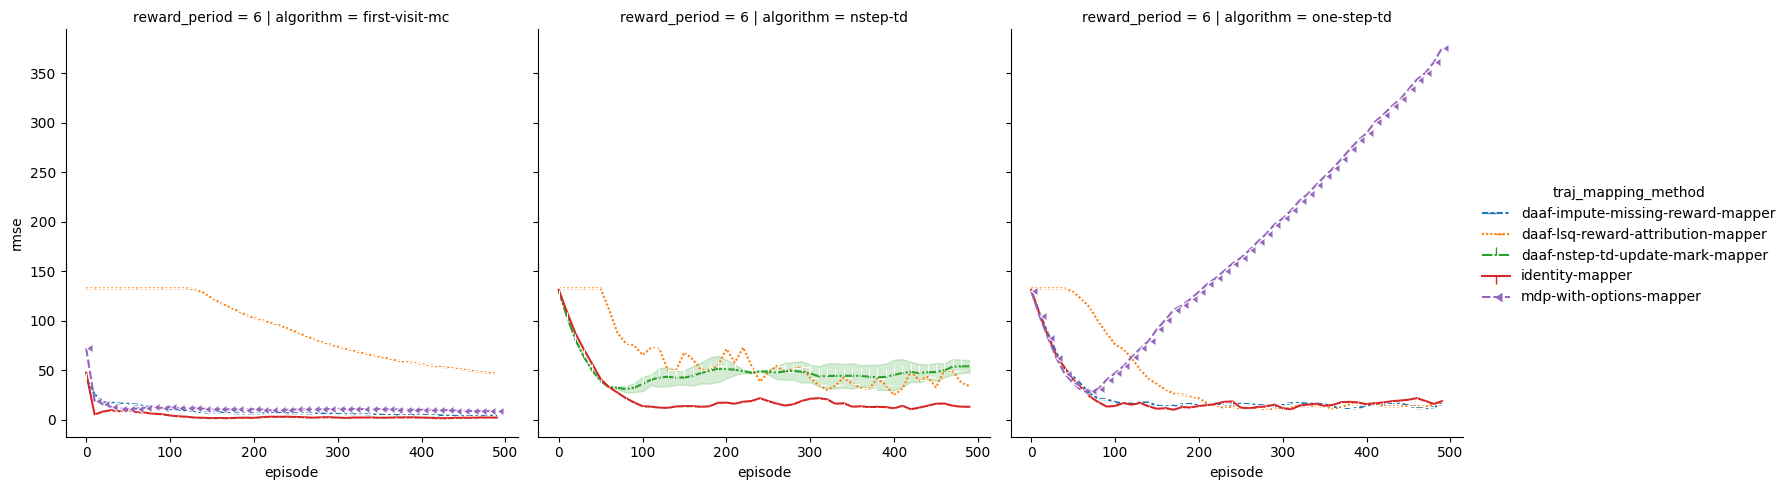

In [24]:
plot_eval_result(
    env="ABCSeq",
    level="7",
    discount_factor=1.0,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


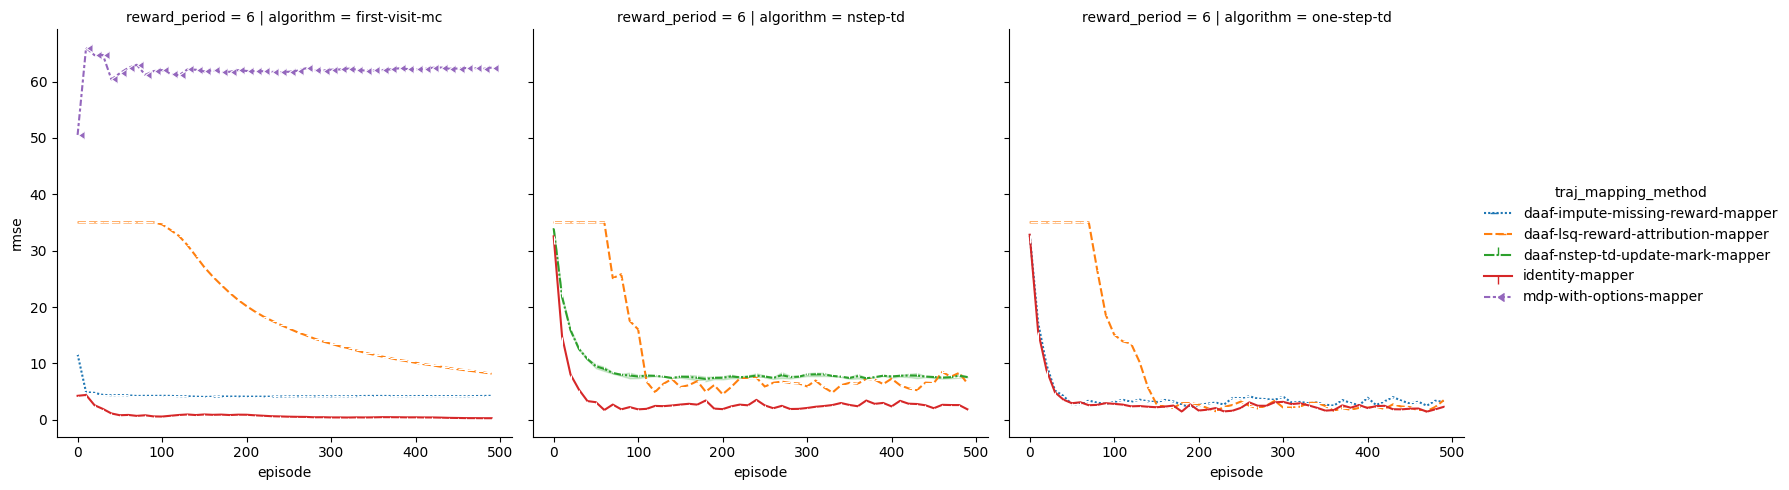

In [25]:
plot_eval_result(
    env="ABCSeq",
    level="7",
    discount_factor=0.9,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


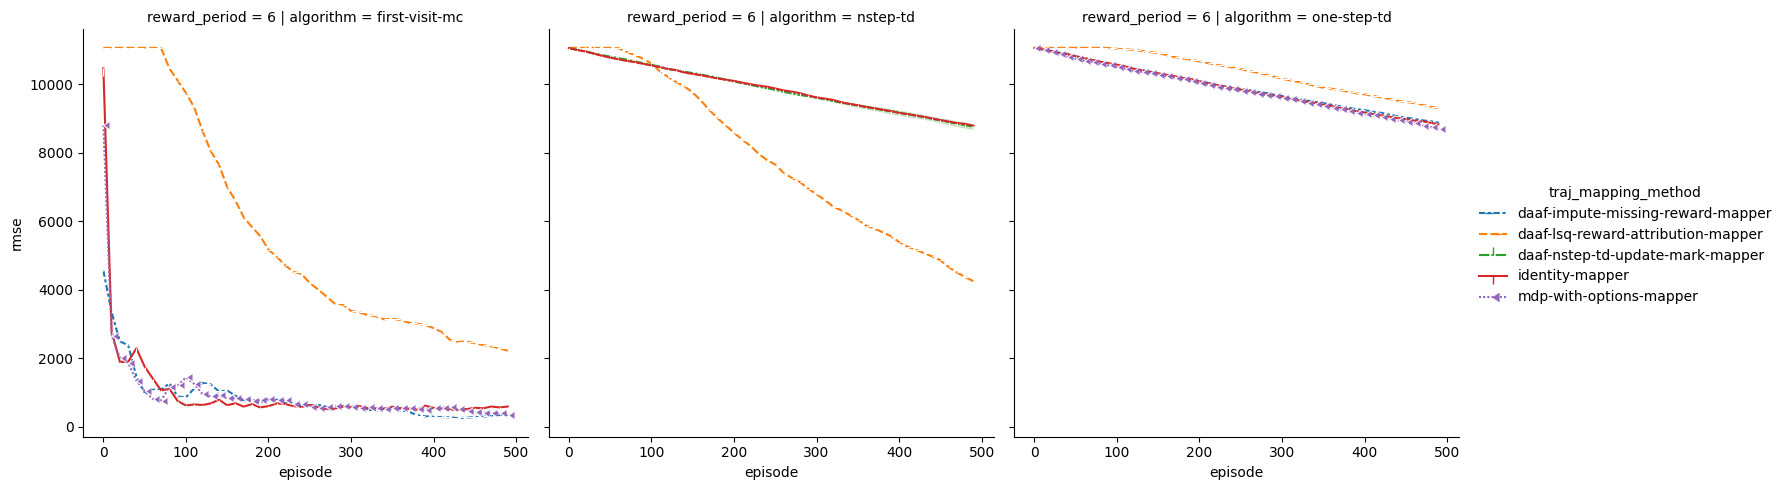

In [26]:
plot_eval_result(
    env="TowerOfHanoi",
    level="5",
    discount_factor=1.0,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


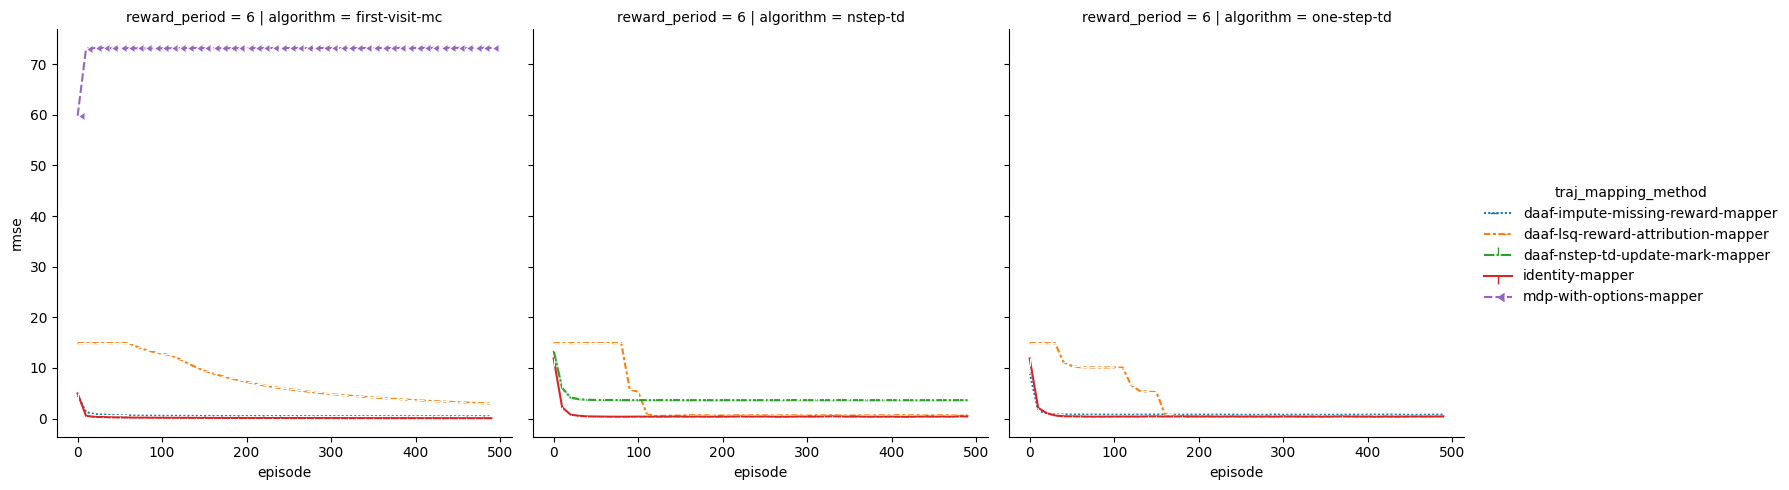

In [27]:
plot_eval_result(
    env="TowerOfHanoi",
    level="5",
    discount_factor=0.9,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


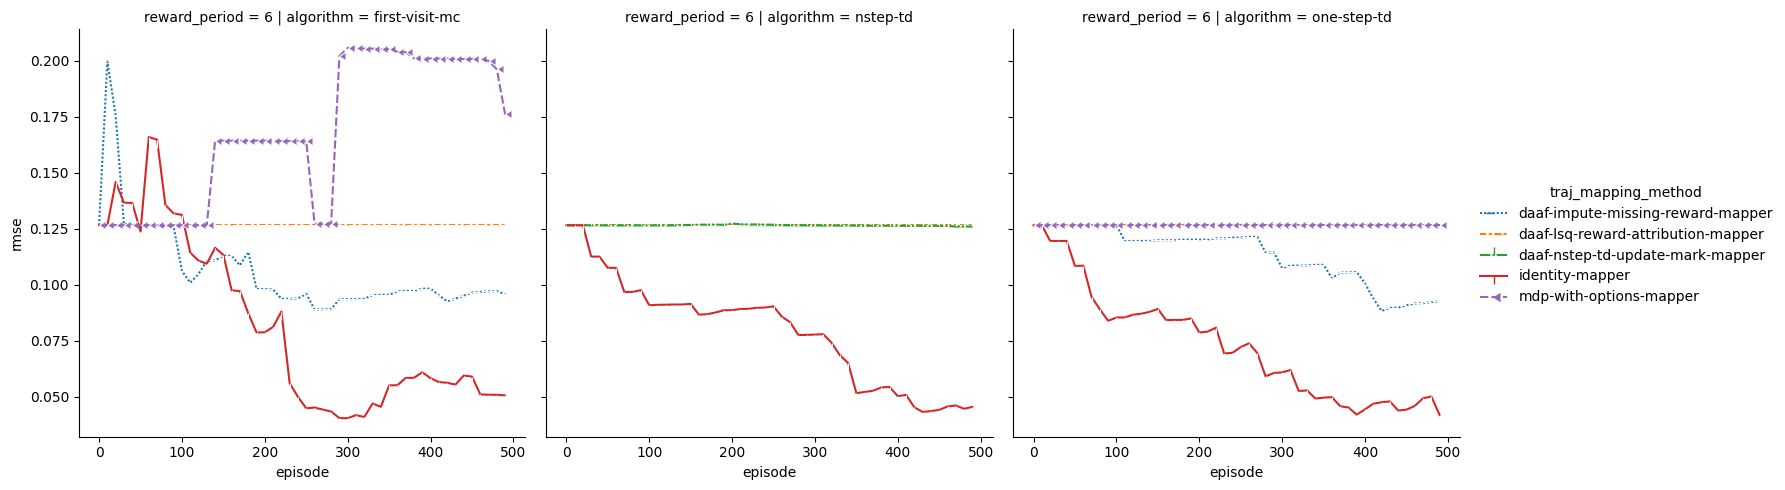

In [28]:
plot_eval_result(
    env="FrozenLake-v1",
    level="U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=",
    discount_factor=1.0,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


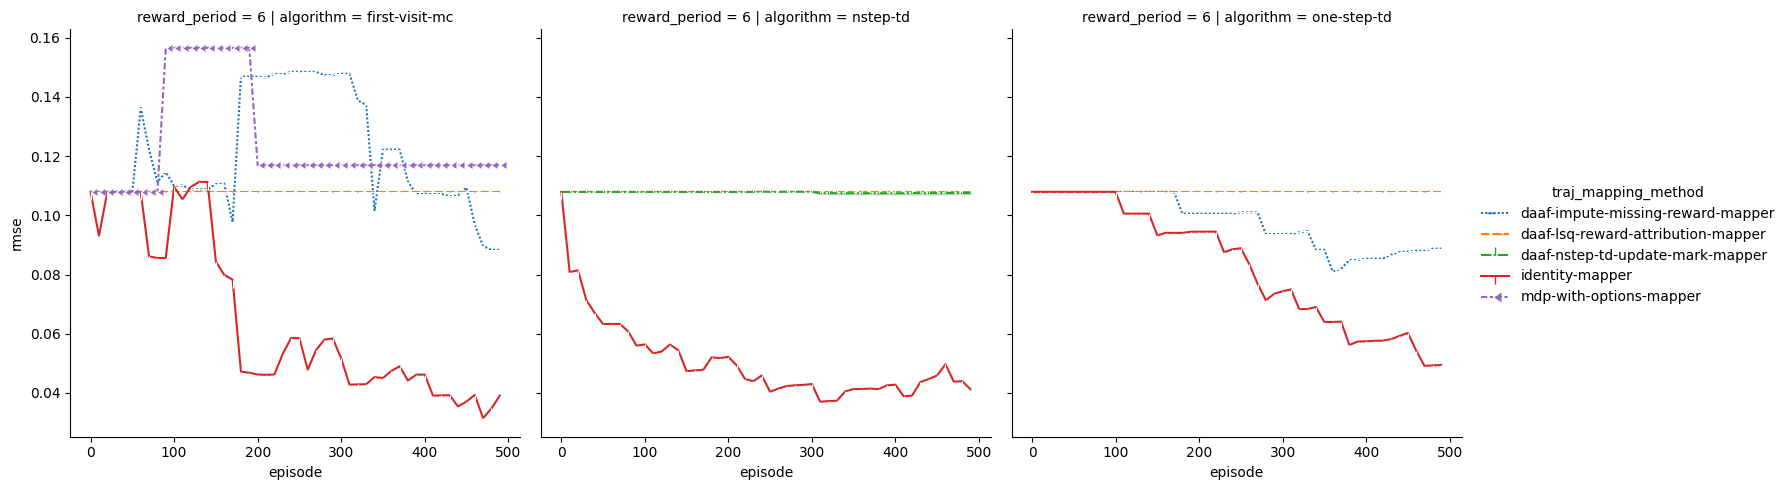

In [29]:
plot_eval_result(
    env="FrozenLake-v1",
    level="U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=",
    discount_factor=0.9,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


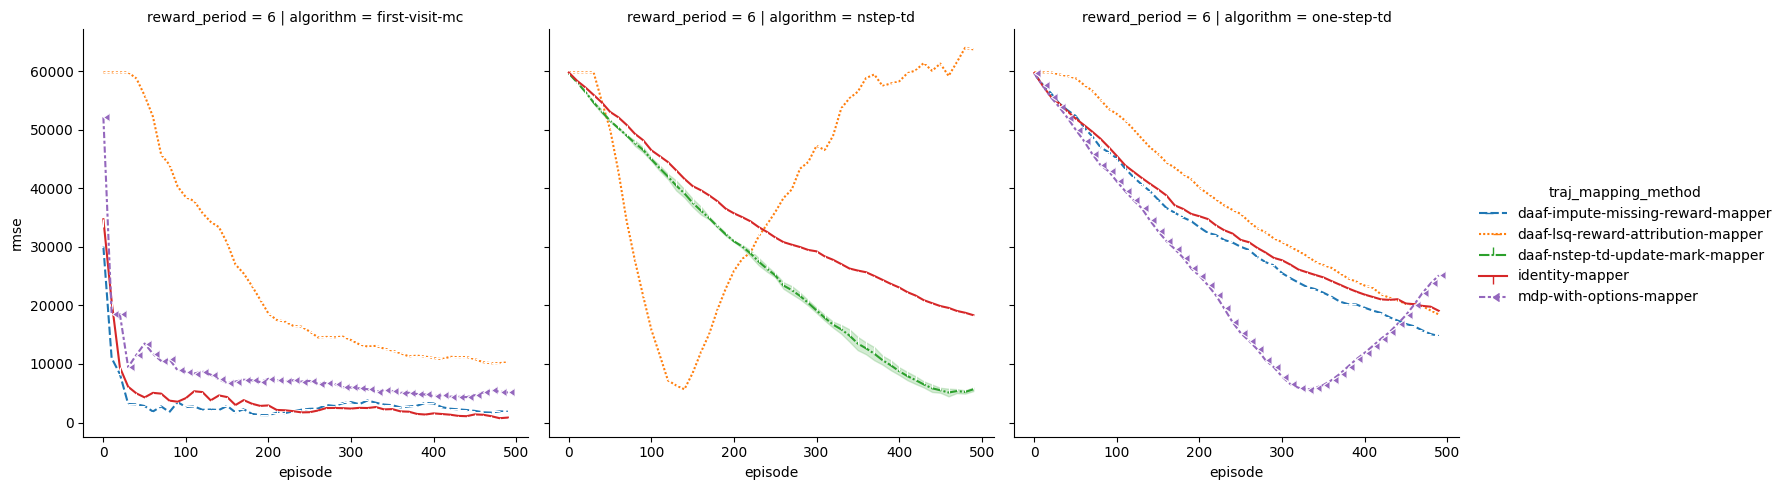

In [30]:
plot_eval_result(
    env="GridWorld",
    level="P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A=",
    discount_factor=1.0,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


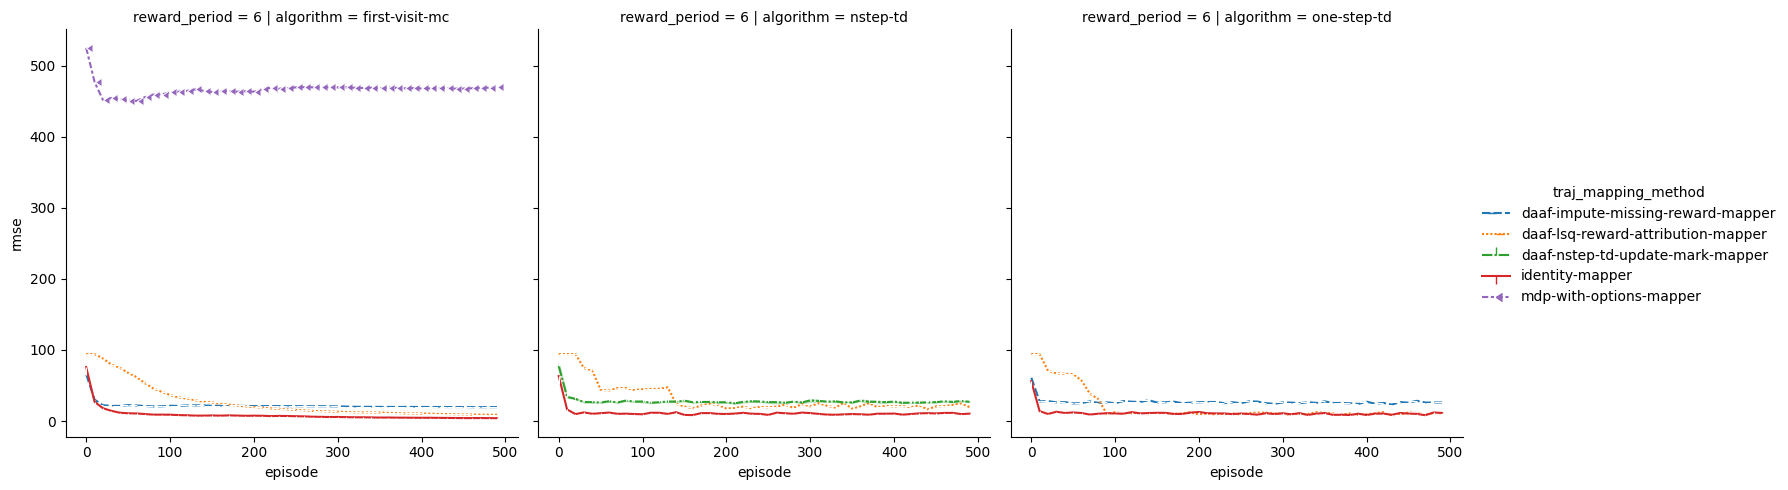

In [31]:
plot_eval_result(
    env="GridWorld",
    level="P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A=",
    discount_factor=0.9,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


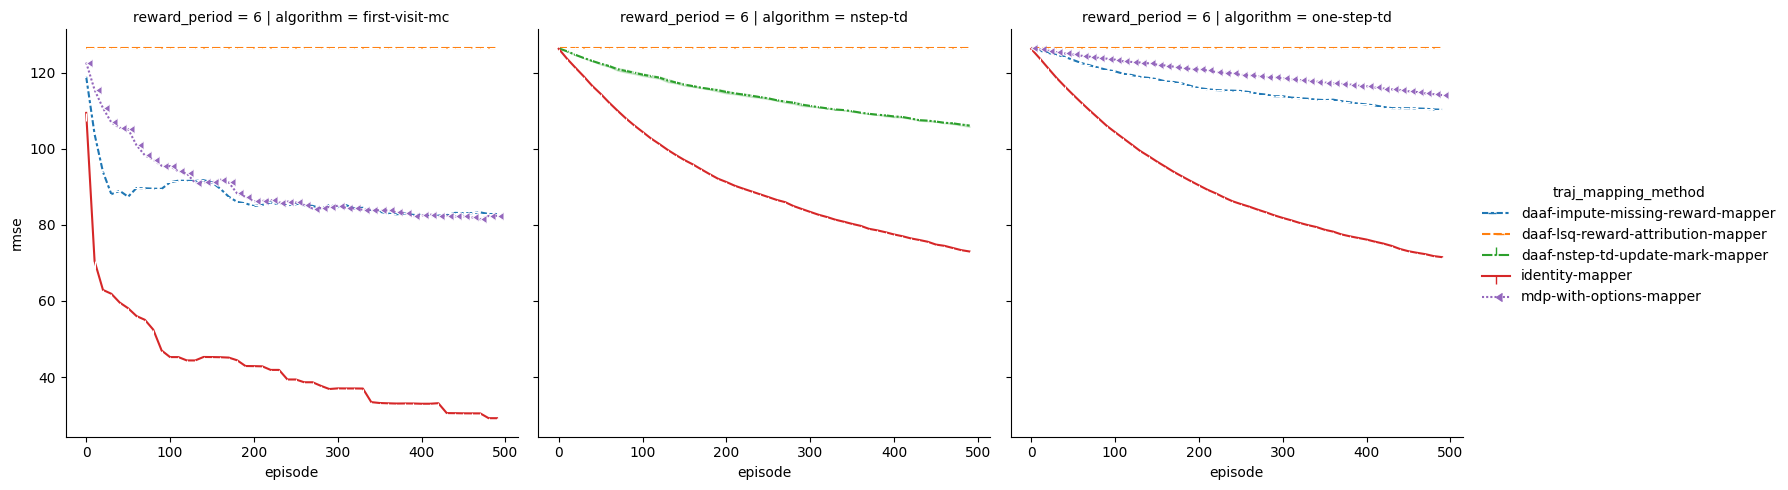

In [32]:
plot_eval_result(
    env="IceWorld",
    level="JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI=",
    discount_factor=1.0,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)


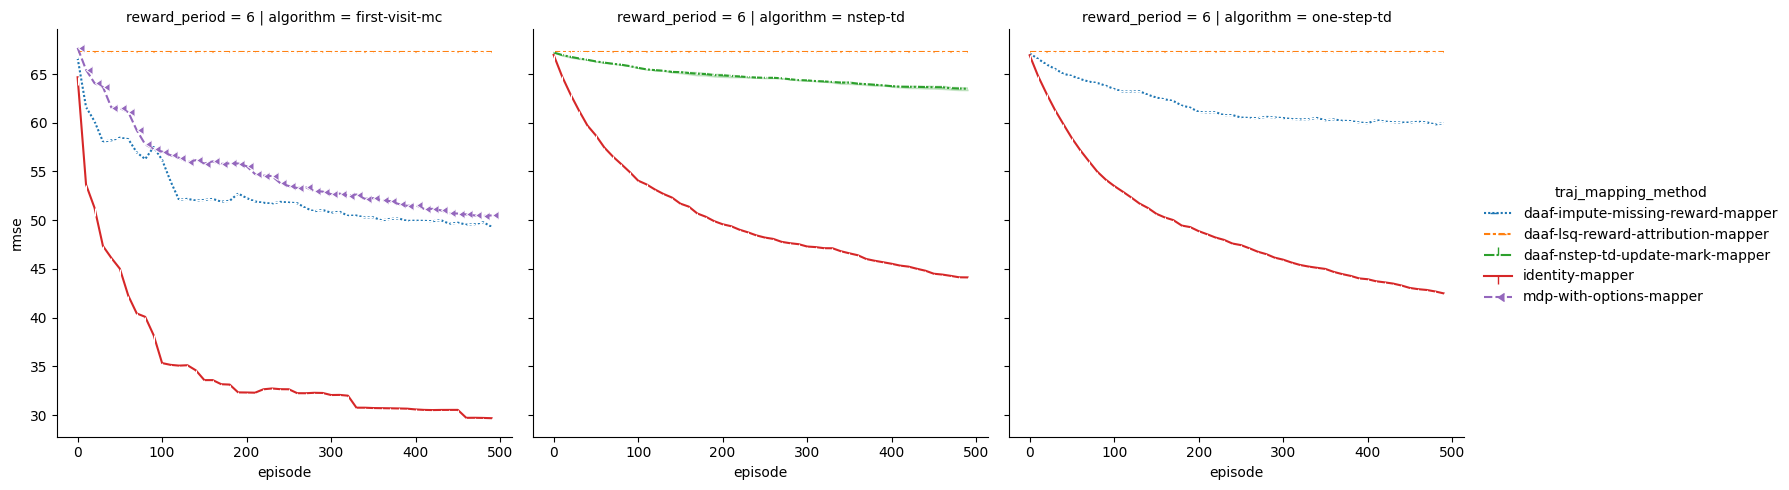

In [33]:
plot_eval_result(
    env="IceWorld",
    level="JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI=",
    discount_factor=0.9,
    drop_truncated=False,
    metric_family="over_states_then_runs",
    metric_col="rmse",
    df_data=df_metrics
)
